**Import Packages**

In [1]:
import pycaret
import pandas as pd
import numpy as np
import sqlalchemy
import mysql.connector

from pycaret import classification
from pycaret.classification import plot_model
from datetime import datetime
import importlib
import model.common

In [2]:
from static_data.load_static_data import *

In [3]:
df_player_team_positions

,Unnamed: 0,player_id,player_name,player_team_id,player_team_name,player_position
0,0,456167,A.J. Griffin,133,Oakland Athletics,Pitcher
1,0,134460,A.J. Hinch,133,Oakland Athletics,Catcher
2,0,640462,A.J. Puk,133,Oakland Athletics,Pitcher
3,0,605156,Aaron Brooks,133,Oakland Athletics,Pitcher
4,0,488811,Aaron Cunningham,133,Oakland Athletics,Outfielder
...,...,...,...,...,...,...
44728,0,451596,Yovani Gallardo,113,Cincinnati Reds,Pitcher
44729,0,435043,Zach Duke,113,Cincinnati Reds,Pitcher
44730,0,572227,Zach Vincej,113,Cincinnati Reds,Infielder
44731,0,446359,Zack Cozart,113,Cincinnati Reds,Infielder


**Load Data**

In [4]:
collect_data_Base_dir = 'collect_data'

In [20]:
df_game_matchup_total = pd.read_pickle(f'{collect_data_Base_dir}/df_game_matchup_total.pkl')
print(len(df_game_matchup_total))

325140


**Clean Data**

In [84]:
importlib.reload(model.common)

<module 'model.common' from '/home/junlim/projects/mlb-props/model/common.py'>

In [85]:
model.common.categorical_features

['game_venue', 'batting_name', 'pitching_name']

In [86]:
train_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2012-04-01") & (df_game_matchup_total.game_date < "2022-12-01")][model.common.features]
test_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2022-12-01")][model.common.features]

In [87]:
train_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_hits_per_pitch', 'pitching_cur_strikeOuts_per_pitch',
       'batting_cur_season_avg', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [89]:
test_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_hits_per_pitch', 'pitching_cur_strikeOuts_per_pitch',
       'batting_cur_season_avg', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [90]:
model.common.categorical_features

['game_venue', 'batting_name', 'pitching_name']

In [91]:
model.common.ignore_features

['pitching_id', 'batting_id', 'game_date', 'game_year']

**Model Setup**

In [92]:
classification_setup = pycaret.classification.setup(
    data = train_data, target = "batting_hit_recorded", train_size = .70, use_gpu = False, 
    categorical_features = ['game_venue'], ignore_features = model.common.ignore_features + ['batting_name', 'pitching_name'])

,Description,Value
0,Session id,3031
1,Target,batting_hit_recorded
2,Target type,Binary
3,Original data shape,"(285090, 21)"
4,Transformed data shape,"(285090, 15)"
5,Transformed train set shape,"(199563, 15)"
6,Transformed test set shape,"(85527, 15)"
7,Ignore features,6
8,Numeric features,12
9,Categorical features,1


**Build/Train Model**

In [93]:
classification_setup.create_model?

Signature:
classification_setup.create_model(
    estimator: Union[str, Any],
    fold: Union[int, Any, NoneType] = None,
    round: int = 4,
    cross_validation: bool = True,
    fit_kwargs: Optional[dict] = None,
    groups: Union[str, Any, NoneType] = None,
    experiment_custom_tags: Optional[Dict[str, Any]] = None,
    probability_threshold: Optional[float] = None,
    engine: Optional[str] = None,
    verbose: bool = True,
    return_train_score: bool = False,
    **kwargs,
) -> Any
Docstring:
This function trains and evaluates the performance of a given estimator
using cross validation. The output of this function is a score grid with
CV scores by fold. Metrics evaluated during CV can be accessed using the
``get_metrics`` function. Custom metrics can be added or removed using
``add_metric`` and ``remove_metric`` function. All the available models
can be accessed using the ``models`` function.

Example
-------
>>> from pycaret.datasets import get_data
>>> juice = get_data('juice

In [96]:
regression_model_rf = classification_setup.create_model("rf", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9905,0.9993,0.9926,0.9906,0.9916,0.9807,0.9807
1,0.9901,0.9994,0.9908,0.9915,0.9912,0.9798,0.9798
2,0.9898,0.9992,0.9917,0.9902,0.9910,0.9793,0.9793
3,0.9900,0.9994,0.9927,0.9896,0.9912,0.9797,0.9797
4,0.9914,0.9994,0.9924,0.9923,0.9924,0.9825,0.9825
5,0.9908,0.9994,0.9922,0.9916,0.9919,0.9814,0.9814
6,0.9899,0.9991,0.9919,0.9901,0.9910,0.9794,0.9794
7,0.9901,0.9995,0.9927,0.9897,0.9912,0.9798,0.9798
8,0.9908,0.9991,0.9925,0.9912,0.9919,0.9814,0.9814


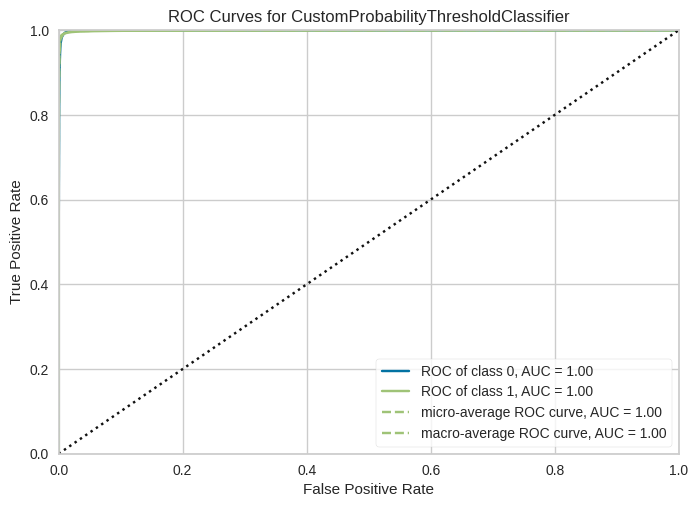

In [97]:
plot_model(regression_model_rf, plot = 'auc')

In [98]:
regression_model_gbc = classification_setup.create_model("gbc", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6710,0.7459,0.8765,0.6556,0.7502,0.2967,0.3246
1,0.6689,0.7502,0.8684,0.6557,0.7472,0.2937,0.3190
2,0.6689,0.7465,0.8785,0.6534,0.7494,0.2915,0.3205
3,0.6694,0.7486,0.8751,0.6545,0.7489,0.2933,0.3209
4,0.6659,0.7450,0.8722,0.6522,0.7463,0.2857,0.3127
5,0.6710,0.7520,0.8742,0.6562,0.7496,0.2972,0.3243
6,0.6661,0.7476,0.8766,0.6514,0.7474,0.2852,0.3138
7,0.6715,0.7543,0.8746,0.6565,0.7500,0.2984,0.3255
8,0.6694,0.7508,0.8705,0.6557,0.7480,0.2944,0.3203


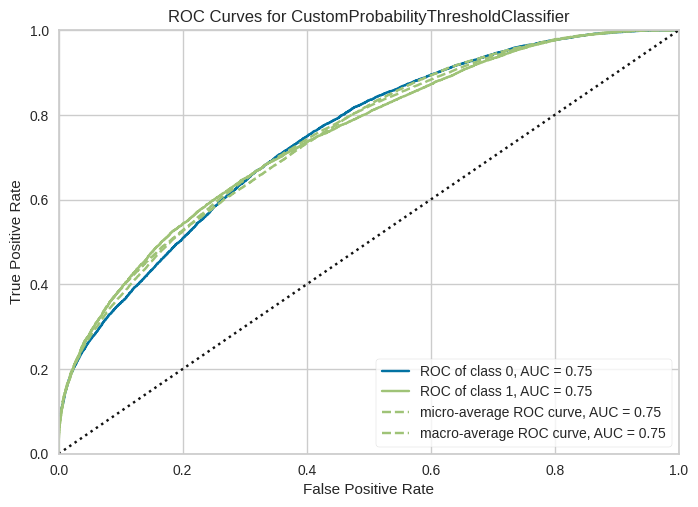

In [99]:
plot_model(regression_model_gbc, plot = 'auc')

In [100]:
regression_model_lightgbm = classification_setup.create_model("lightgbm", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8280,0.9278,0.9241,0.8012,0.8582,0.6423,0.6530
1,0.8390,0.9312,0.9254,0.8142,0.8662,0.6660,0.6747
2,0.8338,0.9273,0.9231,0.8090,0.8623,0.6552,0.6643
3,0.8323,0.9286,0.9154,0.8112,0.8602,0.6526,0.6600
4,0.8297,0.9261,0.9133,0.8091,0.8580,0.6473,0.6547
5,0.8275,0.9273,0.9177,0.8039,0.8571,0.6420,0.6510
6,0.8283,0.9239,0.9213,0.8030,0.8581,0.6434,0.6532
7,0.8415,0.9319,0.9234,0.8185,0.8678,0.6717,0.6793
8,0.8341,0.9258,0.9177,0.8123,0.8618,0.6563,0.6640


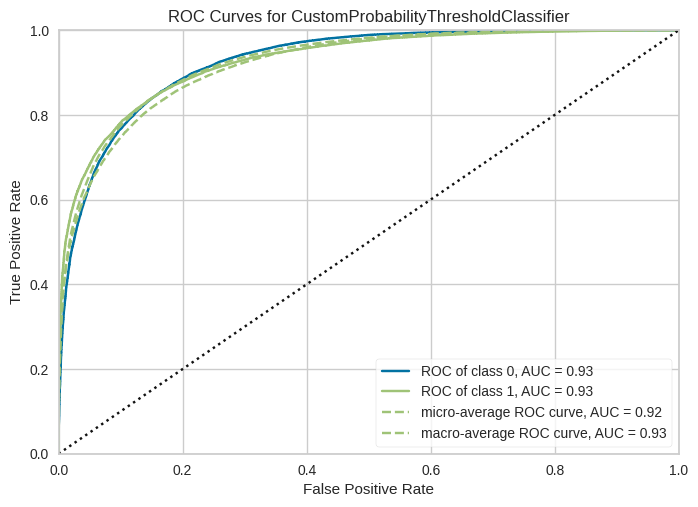

In [101]:
plot_model(regression_model_lightgbm, plot = 'auc')

In [102]:
regression_model_ada = classification_setup.create_model("ada", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6308,0.6724,0.8371,0.6297,0.7187,0.2116,0.2305
1,0.6330,0.6672,0.8350,0.6319,0.7194,0.2173,0.2356
2,0.6318,0.6662,0.8431,0.6293,0.7207,0.2127,0.2331
3,0.6284,0.6617,0.8423,0.6267,0.7187,0.2048,0.2251
4,0.6250,0.6654,0.8395,0.6244,0.7162,0.1976,0.2172
5,0.6286,0.6644,0.8440,0.6266,0.7192,0.2050,0.2257
6,0.6251,0.6630,0.8301,0.6263,0.7139,0.2001,0.2174
7,0.6322,0.6772,0.8340,0.6315,0.7188,0.2159,0.2339
8,0.6261,0.6682,0.8352,0.6261,0.7157,0.2011,0.2196


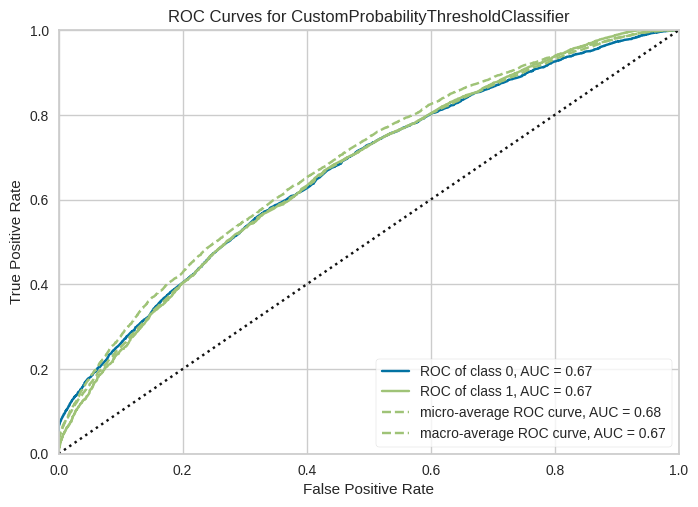

In [103]:
plot_model(regression_model_ada, plot = 'auc')

**evaluate model**

`lightgbm` shows very good AUC of `0.97`, `rf` as well with `1.0` train AUC.

`rf` seemed like too overfit with 1.0 train AUC but its test precision as well is the best among others.

`ada` shows very low recall thus inpractical.


In [64]:
def predict_and_odds(df_data, regression_model):
    df_prediction = pycaret.classification.predict_model(data = df_data, estimator = regression_model)
    df_prediction = pd.merge(df_prediction, df_player_team_positions[['player_id','player_team_name']], left_on='batting_id', right_on='player_id', how='left')
    df_prediction["theo_odds"] = df_prediction["prediction_score"].apply(model.common.odds_calculator)
    return df_prediction

In [65]:
def get_eval_profile(df_prediction, score_threshold):
    confident_prediction = df_prediction.drop_duplicates("batting_name")
    confident_prediction = confident_prediction[confident_prediction["prediction_score"] >= score_threshold]
    # for some reason, the prediction_label should be separatedly checked. higher score does not always lead to prediction label. (maybe the score stands for both labels).
    confident_prediction = confident_prediction[confident_prediction["prediction_label"] == 1]
    l = len(confident_prediction)
    return l, confident_prediction.batting_hit_recorded.sum() / l

In [104]:
train_prediction_ada = predict_and_odds(train_data, regression_model_ada)
train_prediction_gbc = predict_and_odds(train_data, regression_model_gbc)
train_prediction_lightgbm = predict_and_odds(train_data, regression_model_lightgbm)
train_prediction_rf = predict_and_odds(train_data, regression_model_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6283,0.6697,0.8430,0.6264,0.7188,0.2044,0.2249


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6675,0.7511,0.8721,0.6536,0.7472,0.2896,0.3163


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8400,0.9324,0.9277,0.8143,0.8673,0.6681,0.6771


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9974,0.9999,0.9976,0.9978,0.9977,0.9948,0.9948


In [105]:
print(get_eval_profile(train_prediction_ada, 0.6))
print(get_eval_profile(train_prediction_ada, 0.7))
print(get_eval_profile(train_prediction_ada, 0.75))
print(get_eval_profile(train_prediction_ada, 0.80))

(0, nan)
(0, nan)
(0, nan)
(0, nan)


In [106]:
print(get_eval_profile(train_prediction_gbc, 0.6))
print(get_eval_profile(train_prediction_gbc, 0.7))
print(get_eval_profile(train_prediction_gbc, 0.75))
print(get_eval_profile(train_prediction_gbc, 0.80))

(338, 0.6923076923076923)
(75, 0.8666666666666667)
(29, 0.9310344827586207)
(9, 1.0)


In [107]:
print(get_eval_profile(train_prediction_lightgbm, 0.6))
print(get_eval_profile(train_prediction_lightgbm, 0.7))
print(get_eval_profile(train_prediction_lightgbm, 0.75))
print(get_eval_profile(train_prediction_lightgbm, 0.80))

(334, 0.844311377245509)
(162, 0.9259259259259259)
(107, 0.9532710280373832)
(61, 1.0)


In [108]:
print(get_eval_profile(train_prediction_rf, 0.6))
print(get_eval_profile(train_prediction_rf, 0.7))
print(get_eval_profile(train_prediction_rf, 0.75))
print(get_eval_profile(train_prediction_rf, 0.80))

(629, 0.9841017488076311)
(574, 0.9930313588850174)
(514, 0.9961089494163424)
(472, 0.9978813559322034)


**test prediction**

In [109]:
test_prediction_ada = predict_and_odds(test_data, regression_model_ada)
test_prediction_gbc = predict_and_odds(test_data, regression_model_gbc)
test_prediction_lightgbm = predict_and_odds(test_data, regression_model_lightgbm)
test_prediction_rf = predict_and_odds(test_data, regression_model_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.5752,0.5593,0.7799,0.6073,0.6829,0.0690,0.0741


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5627,0.5425,0.7836,0.5968,0.6776,0.0353,0.0386


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5486,0.5252,0.7150,0.5959,0.6501,0.0288,0.0297


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5716,0.5591,0.7082,0.6175,0.6597,0.0888,0.0904


In [110]:
print(get_eval_profile(test_prediction_ada, 0.6))
print(get_eval_profile(test_prediction_ada, 0.7))
print(get_eval_profile(test_prediction_ada, 0.75))
print(get_eval_profile(test_prediction_ada, 0.80))
print(get_eval_profile(test_prediction_ada, 0.85))

(0, nan)
(0, nan)
(0, nan)
(0, nan)
(0, nan)


In [111]:
print(get_eval_profile(test_prediction_gbc, 0.6))
print(get_eval_profile(test_prediction_gbc, 0.7))
print(get_eval_profile(test_prediction_gbc, 0.75))
print(get_eval_profile(test_prediction_gbc, 0.80))
print(get_eval_profile(test_prediction_gbc, 0.85))

(152, 0.5986842105263158)
(28, 0.5714285714285714)
(9, 0.6666666666666666)
(2, 1.0)
(0, nan)


In [112]:
print(get_eval_profile(test_prediction_lightgbm, 0.6))
print(get_eval_profile(test_prediction_lightgbm, 0.7))
print(get_eval_profile(test_prediction_lightgbm, 0.75))
print(get_eval_profile(test_prediction_lightgbm, 0.80))
print(get_eval_profile(test_prediction_lightgbm, 0.85))

(125, 0.568)
(50, 0.66)
(25, 0.68)
(14, 0.7857142857142857)
(4, 0.75)


In [113]:
print(get_eval_profile(test_prediction_rf, 0.6))
print(get_eval_profile(test_prediction_rf, 0.7))
print(get_eval_profile(test_prediction_rf, 0.75))
print(get_eval_profile(test_prediction_rf, 0.80))
print(get_eval_profile(test_prediction_rf, 0.85))

(137, 0.5912408759124088)
(52, 0.6346153846153846)
(21, 0.7619047619047619)
(7, 0.8571428571428571)
(2, 0.5)


**Finalize Model**

In [114]:
# train over the whole dataset without validation split
regression_model_finalized_ada = pycaret.classification.finalize_model(regression_model_ada)
regression_model_finalized_gbc = pycaret.classification.finalize_model(regression_model_gbc)
regression_model_finalized_lightgbm = pycaret.classification.finalize_model(regression_model_lightgbm)
regression_model_finalized_rf = pycaret.classification.finalize_model(regression_model_rf)

In [115]:
test_finalized_prediction_ada = predict_and_odds(test_data, regression_model_finalized_ada)
test_finalized_prediction_gbc = predict_and_odds(test_data, regression_model_finalized_gbc)
test_finalized_prediction_lightgbm = predict_and_odds(test_data, regression_model_finalized_lightgbm)
test_finalized_prediction_rf = predict_and_odds(test_data, regression_model_finalized_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.5666,0.5562,0.7684,0.6023,0.6752,0.0518,0.0553


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5690,0.5468,0.7824,0.6019,0.6804,0.0519,0.0563


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5520,0.5389,0.7247,0.5973,0.6548,0.0333,0.0345


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5697,0.5533,0.7029,0.6169,0.6571,0.0863,0.0876


In [116]:
print(get_eval_profile(test_finalized_prediction_ada, 0.6))
print(get_eval_profile(test_finalized_prediction_ada, 0.7))
print(get_eval_profile(test_finalized_prediction_ada, 0.75))
print(get_eval_profile(test_finalized_prediction_ada, 0.80))
print(get_eval_profile(test_finalized_prediction_ada, 0.85))

(0, nan)
(0, nan)
(0, nan)
(0, nan)
(0, nan)


In [117]:
print(get_eval_profile(test_finalized_prediction_gbc, 0.6))
print(get_eval_profile(test_finalized_prediction_gbc, 0.7))
print(get_eval_profile(test_finalized_prediction_gbc, 0.75))
print(get_eval_profile(test_finalized_prediction_gbc, 0.80))
print(get_eval_profile(test_finalized_prediction_gbc, 0.85))

(146, 0.5958904109589042)
(36, 0.6111111111111112)
(9, 0.6666666666666666)
(4, 0.75)
(0, nan)


In [118]:
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.6))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.7))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.75))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.80))
print(get_eval_profile(test_finalized_prediction_lightgbm, 0.85))

(140, 0.5928571428571429)
(57, 0.6491228070175439)
(25, 0.84)
(10, 1.0)
(4, 1.0)


In [119]:
print(get_eval_profile(test_finalized_prediction_rf, 0.6))
print(get_eval_profile(test_finalized_prediction_rf, 0.7))
print(get_eval_profile(test_finalized_prediction_rf, 0.75))
print(get_eval_profile(test_finalized_prediction_rf, 0.80))
print(get_eval_profile(test_finalized_prediction_rf, 0.85))

(150, 0.56)
(50, 0.58)
(27, 0.7407407407407407)
(9, 0.7777777777777778)
(3, 1.0)


**Save Model**

In [121]:
pycaret.classification.save_model(regression_model_finalized_lightgbm, model.common.model_file_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pitching_gamesPlayed',
                                              'pitching_runs_per_game',
                                              'pitching_strikeOuts_per_game',
                                              'pitching_hits_per_game',
                                              'batting_gamesPlayed',
                                              'batting_runs_per_game',
                                              'batting_strikeOuts_per_game',
                                              'batting_hits_per_game',
                                              'batting_rbi',
                                              'pitching_cur_...
                                                       colsample_bytree=1.0,
                                                       importance_type='split